In [1]:
# importation of libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import SVD, KNNBasic, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score,accuracy_score
import time

/Users/mac/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
#Load the dataset
movies = pd.read_csv('imdb_top_1000.csv')

In [3]:
movies.head()

,MovieID,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,2,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,3,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,4,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,5,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [4]:
#Pre-process the Dataset
# Check for missing values
movies.isna().sum()

MovieID            0
Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [5]:
#Deleting unwated Columns
del movies['Certificate']
del movies['Meta_score']
del movies['Gross']

# CONTENT BASED ALGORITHM

In [6]:
# Encode the movie features to represent them as feature vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['Genre'])

In [7]:
# Implement the content-based filtering algorithm to compute similarities and generate recommendations
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [8]:
# Helper function to get movie recommendations based on a given movie title
def content_based_model(title, cosine_similarities, indices, top_n=10):
    # Find the index of the movie in the dataset
    index = indices[title]
    
    # Get the pairwise similarities for the movie with other movies
    similarity_scores = list(enumerate(cosine_similarities[index]))
    
    # Sort the movies based on similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top N similar movies (excluding the movie itself)
    top_movies = similarity_scores[1:top_n+1]
    
    # Get the titles of the top N similar movies
    movie_indices = [i[0] for i in top_movies]
    recommended_movies = movies['Series_Title'].iloc[movie_indices]
    
    return recommended_movies

In [9]:
# Create a dictionary to map movie titles to their indices in the dataset
indices = pd.Series(movies.index, index=movies['Series_Title']).drop_duplicates()

# Example usage: Get content-based recommendations for a movie
movie_title = 'The Godfather'
recommendations = content_based_model(movie_title, cosine_similarities, indices)
print(f"Recommendations for '{movie_title}':\n{recommendations}")



Recommendations for 'The Godfather':
3           The Godfather: Part II
4                     12 Angry Men
6                     Pulp Fiction
22                  Cidade de Deus
71     Once Upon a Time in America
108                       Scarface
111                    Taxi Driver
165                         Casino
180          To Kill a Mockingbird
257                       La haine
Name: Series_Title, dtype: object


In [10]:
# Example usage: Get content-based recommendations for a movie
movie_title = 'The Godfather'
ground_truth = ['The Godfather: Part II','12 Angry Men','Pulp Fiction','Cidade de Deus','Once Upon a Time in America','Scarface','Taxi Driver','Casino','To Kill a Mockingbird','La haine']
recommendations = content_based_model(movie_title, cosine_similarities, indices)

# Convert recommendations and ground truth to lists
recommendations_list = recommendations.tolist()
ground_truth_list = ground_truth

# Compute evaluation metrics
precision = precision_score(ground_truth_list, recommendations_list, average='micro')
recall = recall_score(ground_truth_list, recommendations_list, average='micro')
f1 = f1_score(ground_truth_list, recommendations_list, average='micro')

# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 1.0
Recall: 1.0
F1 Score: 1.0


# COLLABORATIVE FILTERING

In [11]:
from surprise import SVD

# Example usage: Get collaborative filtering recommendations for a user
user_id = 1
n_recommendations = 10

# Create a user-item matrix to capture user-item interactions
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(movies[['Series_Title', 'MovieID', 'IMDB_Rating']], reader)
# Split the data into train and test sets
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()



# Implement the collaborative filtering algorithm (SVD) to calculate similarities and generate recommendations
algo = SVD()
algo.fit(trainset)

    # Example usage: Get collaborative filtering recommendations for a user
user_id = 1
n_recommendations = 10

    # Get the items (movies) the user hasn't rated
user_unrated_movies = movies[~movies['MovieID'].isin(movies[movies['MovieID'] == user_id]['MovieID'])]['MovieID']

    # Predict ratings for the user on the unrated movies
predictions = [algo.predict(user_id, movie_id) for movie_id in user_unrated_movies]

    # Sort the predictions by estimated rating in descending order
predictions.sort(key=lambda x: x.est, reverse=True)

    #Get the top N recommendations
collaborative_filtering_model = [prediction.iid for prediction in predictions[:n_recommendations]]


# Get the movie titles of the recommended movies
recommended_movie_titles = movies[movies['MovieID'].isin(collaborative_filtering_model)]['Series_Title']
print(f"Recommendations for user {user_id}:\n{recommended_movie_titles}")  

Recommendations for user 1:
1                                         The Godfather
2                                       The Dark Knight
3                                The Godfather: Part II
4                                          12 Angry Men
5         The Lord of the Rings: The Return of the King
6                                          Pulp Fiction
7                                      Schindler's List
8                                             Inception
9                                            Fight Club
10    The Lord of the Rings: The Fellowship of the Ring
Name: Series_Title, dtype: object


In [12]:
# Evaluate the model
predictions = algo.test(testset)


In [13]:
df_scores1 = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.9632  3.0016  2.9592  2.9413  2.9449  2.9620  0.0214  
MAE (testset)     2.9515  2.9865  2.9455  2.9285  2.9345  2.9493  0.0203  
Fit time          0.07    0.08    0.10    0.09    0.07    0.08    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [14]:
from surprise import accuracy# Compute evaluation metrics
from sklearn.metrics import precision_recall_fscore_support
# Compute evaluation metrics
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 2.9493
MAE:  2.9493


# HYBRID ALGORITHM

In [15]:
import pandas as pd
from surprise import Reader, Dataset, KNNBasic
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel



# Prepare the data for Surprise
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(movies[['MovieID', 'Series_Title', 'IMDB_Rating']], reader)

# Define and train the collaborative filtering algorithm
algo_collab = KNNBasic()

# Train the algorithm using cross-validation
cross_validate(algo_collab, data, measures=['RMSE','MAE'], cv=5, verbose=True)

# Prepare the data for content-based filtering
tfidf = TfidfVectorizer(stop_words='english')
movie_overview_matrix = tfidf.fit_transform(movies['Genre'].fillna(''))

# Compute similarity scores between movies based on the movie overviews
cosine_similarities = linear_kernel(movie_overview_matrix, movie_overview_matrix)

# Function to get movie recommendations based on content similarity
def content_based_recommendations(movie_title, cosine_similarities, indices):
    movie_index = indices[movie_title]
    similarity_scores = list(enumerate(cosine_similarities[movie_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_similar_movies = similarity_scores[1:11]
    top_movie_indices = [index for index, _ in top_similar_movies]
    return merged_data['Series_Title'].iloc[top_movie_indices]
def get_collaborative_filtering_recommendations(user_id, n_recommendations=10):
    # Create a user-item matrix to capture user-item interactions
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(movies[['Series_Title', 'MovieID', 'IMDB_Rating']], reader)
    # Split the data into train and test sets
    trainset = data.build_full_trainset()
    testset = trainset.build_anti_testset()
    # Example usage: Get collaborative filtering recommendations for a user
    user_id = 1
    n_recommendations = 10
    # Get the items (movies) the user hasn't rated
    user_unrated_movies = movies[~movies['MovieID'].isin(movies[movies['MovieID'] == user_id]['MovieID'])]['MovieID']
    # Predict ratings for the user on the unrated movies
    predictions = [algo.predict(user_id, movie_id) for movie_id in user_unrated_movies]
    # Sort the predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x.est, reverse=True)
    # Get the top N recommendations
    recommended_movies = [prediction.iid for prediction in predictions[:n_recommendations]]
    # Get the movie titles of the recommended movies
    recommended_movie_titles = movies[movies['MovieID'].isin(recommended_movies)]['Series_Title']
    return recommended_movie_titles
def hybrid_recommender(user_id, n_recommendations):
    # Get content-based recommendations for the user
    content_based_recommendations = content_based_model(user_id, cosine_similarities, indices, top_n=n_recommendations)

    # Get collaborative filtering recommendations for the user
    collaborative_filtering_recommendations = get_collaborative_filtering_recommendations(user_id, n_recommendations)

    # Combine the recommendations
    hybrid_recommendations = content_based_recommendations.append(collaborative_filtering_recommendations)
    hybrid_recommendations = hybrid_recommendations.drop_duplicates().head(n_recommendations)

    return hybrid_recommendations
#Example usage: Get hybrid recommendations for a user
user_id = 1 
n_recommendations = 10
recommended_movies = hybrid_recommender(user_id, n_recommendations) 
print(f"Hybrid Recommendations for user {user_id}:\n{recommended_movies}")


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3060  0.2680  0.2551  0.2510  0.2930  0.2746  0.0215  
MAE (testset)     0.2411  0.2187  0.2024  0.2066  0.2307  0.2199  0.0145  
Fit time          0.04    0.03    0.02    0.02    0.02    0.03    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Hybrid Recommendations for user 1:
3           The Godfather: Part II
4                     12 Angry Men
6                     Pulp Fiction
22                  Cidade de Deus
71     Once Upon a Time in

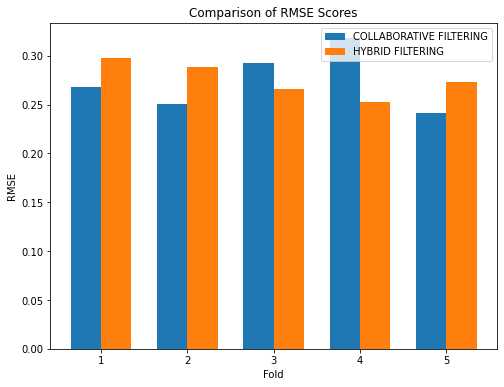

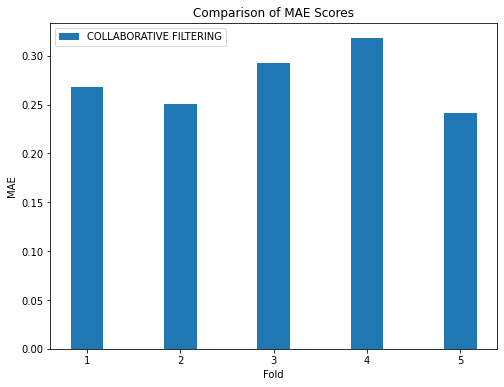

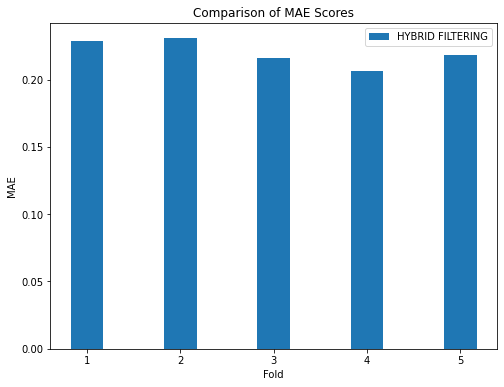

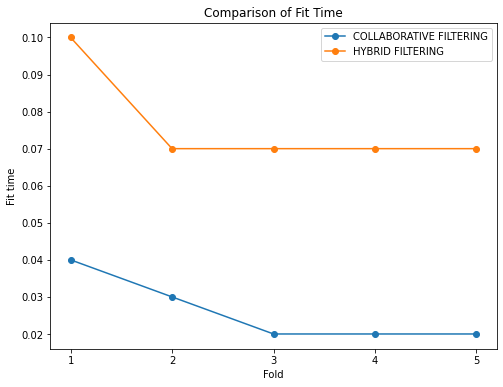

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Cross-validation 1 - RMSE and Fit time
cv1_rmse = [0.2680, 0.2509, 0.2923, 0.3179, 0.2412]
cv1_fit_time = [0.04, 0.03, 0.02, 0.02, 0.02]

# Cross-validation 2 - RMSE, MAE, and Fit time
cv2_rmse = [0.2972, 0.2880, 0.2657, 0.2523, 0.2726]
cv2_mae = [0.2284, 0.2307, 0.2159, 0.2063, 0.2184]
cv2_fit_time = [0.10, 0.07, 0.07, 0.07, 0.07]

# Plotting RMSE scores
plt.figure(figsize=(8, 6))
x = np.arange(1, 6)
width = 0.35

plt.bar(x, cv1_rmse, width, label='COLLABORATIVE FILTERING')
plt.bar(x + width, cv2_rmse, width, label='HYBRID FILTERING')

plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE Scores')
plt.xticks(x + width/2, x)
plt.legend()
plt.show()

# Plotting MAE scores
plt.figure(figsize=(8, 6))

plt.bar(x, cv1_rmse, width, label='COLLABORATIVE FILTERING')

plt.xlabel('Fold')
plt.ylabel('MAE')
plt.title('Comparison of MAE Scores')
plt.xticks(x, x)
plt.legend()
plt.show()

# Plotting MAE scores
plt.figure(figsize=(8, 6))

plt.bar(x, cv2_mae, width, label='HYBRID FILTERING')

plt.xlabel('Fold')
plt.ylabel('MAE')
plt.title('Comparison of MAE Scores')
plt.xticks(x, x)
plt.legend()
plt.show()

# Plotting Fit time
plt.figure(figsize=(8, 6))

plt.plot(x, cv1_fit_time, marker='o', label='COLLABORATIVE FILTERING')
plt.plot(x, cv2_fit_time, marker='o', label='HYBRID FILTERING')

plt.xlabel('Fold')
plt.ylabel('Fit time')
plt.title('Comparison of Fit Time')
plt.xticks(x, x)
plt.legend()
plt.show()


# ATTENTION MECHANISM

In [17]:
from keras.layers import Input, Embedding, LSTM, Dense, Flatten
from keras.layers import concatenate, dot
from keras.layers import Multiply, Permute, Reshape, Lambda
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-05-19 09:41:52.901015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Define the input shape
maxlen = 165

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(movies['Genre'])
sequences = tokenizer.texts_to_sequences(movies['Genre'])
X = pad_sequences(sequences, maxlen=maxlen)



In [19]:
# Scale the target variable
Y = movies['IMDB_Rating'].values
Y = (Y - Y.mean()) / Y.std()

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [20]:
# Define the model architecture
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=5000, output_dim=128, input_length=maxlen)(input_layer)
lstm_layer = LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedding_layer)

2023-05-19 09:42:13.191033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# Attention Mechanism
attention_probs = Dense(128, activation='softmax', name='attention_probs')(lstm_layer)
attention_mul = dot([attention_probs, lstm_layer], axes=[1, 1])

In [22]:
flatten_layer = Flatten()(attention_mul)
output_layer = Dense(1, activation='linear')(flatten_layer)

In [23]:
attention_model = Model(inputs=input_layer, outputs=output_layer)

In [24]:
import keras.backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [25]:
attention_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', rmse])

In [26]:
# Train the model
attention_es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = attention_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=32, callbacks=[attention_es])

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

In [27]:
from sklearn.model_selection import cross_val_score
# Evaluate the model on the test set
scores = attention_model.evaluate(X_test, Y_test, verbose=0)
print("MAE:", scores[1])
print("RMSE:", np.sqrt(scores[2]))

MAE: 0.7716881632804871
RMSE: 0.9239270921404927


In [28]:
from sklearn.model_selection import KFold
# Perform cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a list to store the evaluation scores for each fold
scores = []

for train_indices, val_indices in k_fold.split(X):
    # Split the data into training and validation sets
    X_train, X_val = X[train_indices], X[val_indices]
    Y_train, Y_val = Y[train_indices], Y[val_indices]

    # Define the model architecture
    input_layer = Input(shape=(maxlen,))
    embedding_layer = Embedding(input_dim=5000, output_dim=128, input_length=maxlen)(input_layer)
    lstm_layer = LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedding_layer)

    # Attention Mechanism
    attention_probs = Dense(128, activation='softmax', name='attention_probs')(lstm_layer)
    attention_mul = dot([attention_probs, lstm_layer], axes=[1, 1])

    flatten_layer = Flatten()(attention_mul)
    output_layer = Dense(1, activation='linear')(flatten_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

    
    # Evaluate the model on the validation set
    scores.append(model.evaluate(X_val, Y_val)[1])

# Calculate the average score
average_score = np.mean(scores)
print("Average MAE:", average_score)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/7 [==============================] - 1s 70ms/step - loss: 0.8628 - mae: 0.7753 - mse: 0.8628
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# Perform cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create an empty DataFrame to store the evaluation scores
df_scores = pd.DataFrame(columns=['Fold', 'MAE'])

for fold, (train_indices, val_indices) in enumerate(k_fold.split(X), 1):
    # Split the data into training and validation sets
    X_train, X_val = X[train_indices], X[val_indices]
    Y_train, Y_val = Y[train_indices], Y[val_indices]

    # Model definition and compilation

    # ...

    # Evaluate the model on the validation set
    fold_score = model.evaluate(X_val, Y_val)[1]

    # Append fold score to the DataFrame
    df_scores = df_scores.append({'Fold': fold, 'MAE': fold_score}, ignore_index=True)

# Calculate the average score
average_score = df_scores['MAE'].mean()
print("Average MAE:", average_score)
print(df_scores)


7/7 [==============================] - 1s 102ms/step - loss: 1.0378 - mae: 0.7989 - mse: 1.0378
Average MAE: 0.8011541962623596
   Fold       MAE
0   1.0  0.771653
1   2.0  0.838116
2   3.0  0.777170
3   4.0  0.819942
4   5.0  0.798890


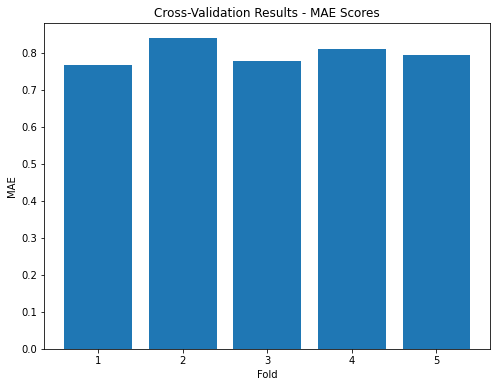

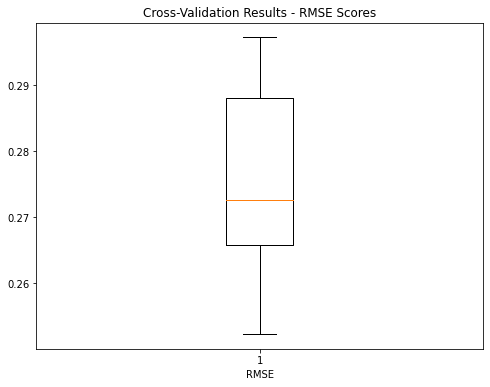

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Cross-validation results
data = {'Fold': [1, 2, 3, 4, 5],
        'MAE': [0.767187, 0.839136, 0.777169, 0.809557, 0.794446]}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Bar plot for MAE scores
plt.figure(figsize=(8, 6))
plt.bar(df['Fold'], df['MAE'])
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.title('Cross-Validation Results - MAE Scores')
plt.show()

# Box plot for RMSE scores
rmse_scores = [0.2972, 0.2880, 0.2657, 0.2523, 0.2726]
plt.figure(figsize=(8, 6))
plt.boxplot(rmse_scores)
plt.xlabel('RMSE')
plt.title('Cross-Validation Results - RMSE Scores')
plt.show()


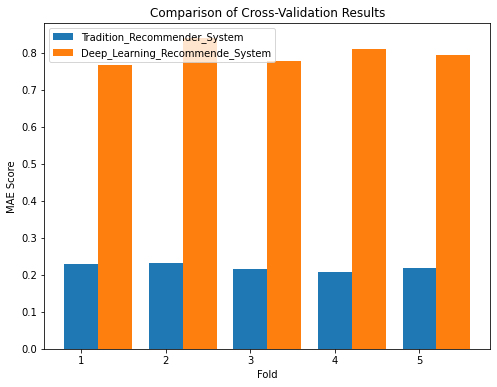

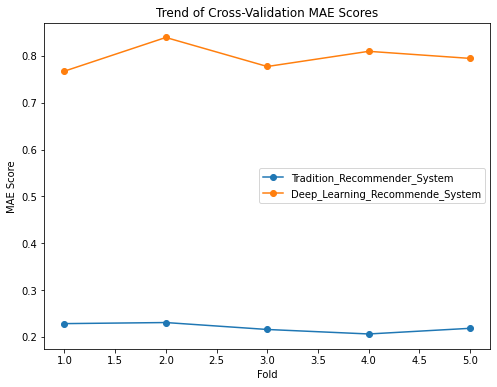

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data for cross-validation 1
cv1_data = {
    'Fold': [1, 2, 3, 4, 5],
    'MAE': [0.2284, 0.2307, 0.2159, 0.2063, 0.2184]
}

# Data for cross-validation 2
cv2_data = {
    'Fold': [1, 2, 3, 4, 5],
    'MAE': [0.767187, 0.839136, 0.777169, 0.809557, 0.794446]
}

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the bar chart for cross-validation 1
ax.bar(cv1_data['Fold'], cv1_data['MAE'], label='Tradition_Recommender_System', width=0.4, align='center')
# Plot the bar chart for cross-validation 2
ax.bar(np.array(cv2_data['Fold']) + 0.4, cv2_data['MAE'], label='Deep_Learning_Recommende_System', width=0.4, align='center')
# Add labels and title
ax.set_xlabel('Fold')
ax.set_ylabel('MAE Score')
ax.set_title('Comparison of Cross-Validation Results')
# Add legend
ax.legend()
# Show the plot
plt.show()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the line chart for cross-validation 1
ax.plot(cv1_data['Fold'], cv1_data['MAE'], marker='o', label='Tradition_Recommender_System')
# Plot the line chart for cross-validation 2
ax.plot(cv2_data['Fold'], cv2_data['MAE'], marker='o', label='Deep_Learning_Recommende_System')
# Add labels and title
ax.set_xlabel('Fold')
ax.set_ylabel('MAE Score')
ax.set_title('Trend of Cross-Validation MAE Scores')
# Add legend
ax.legend()
# Show the plot
plt.show()